[*********************100%%**********************]  1 of 1 completed


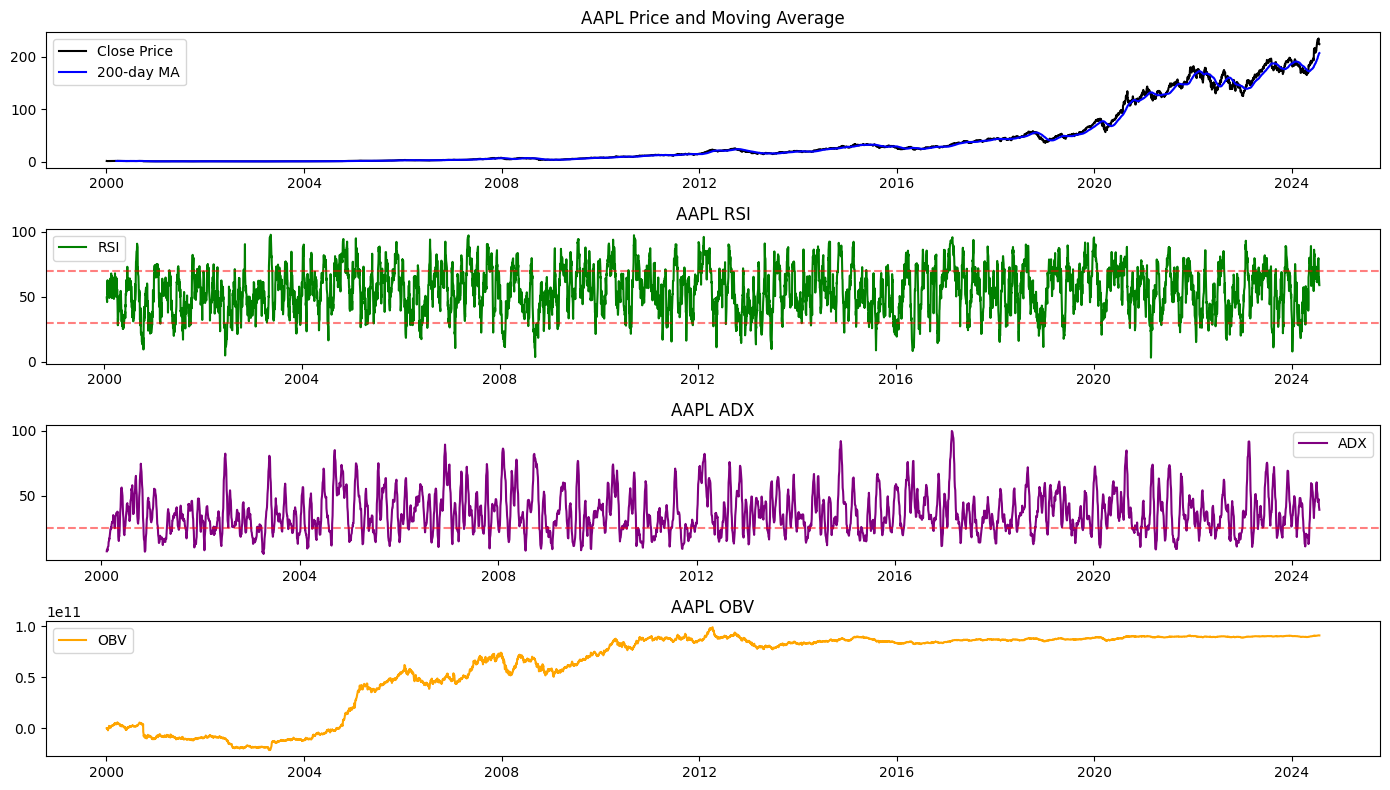

[*********************100%%**********************]  1 of 1 completed


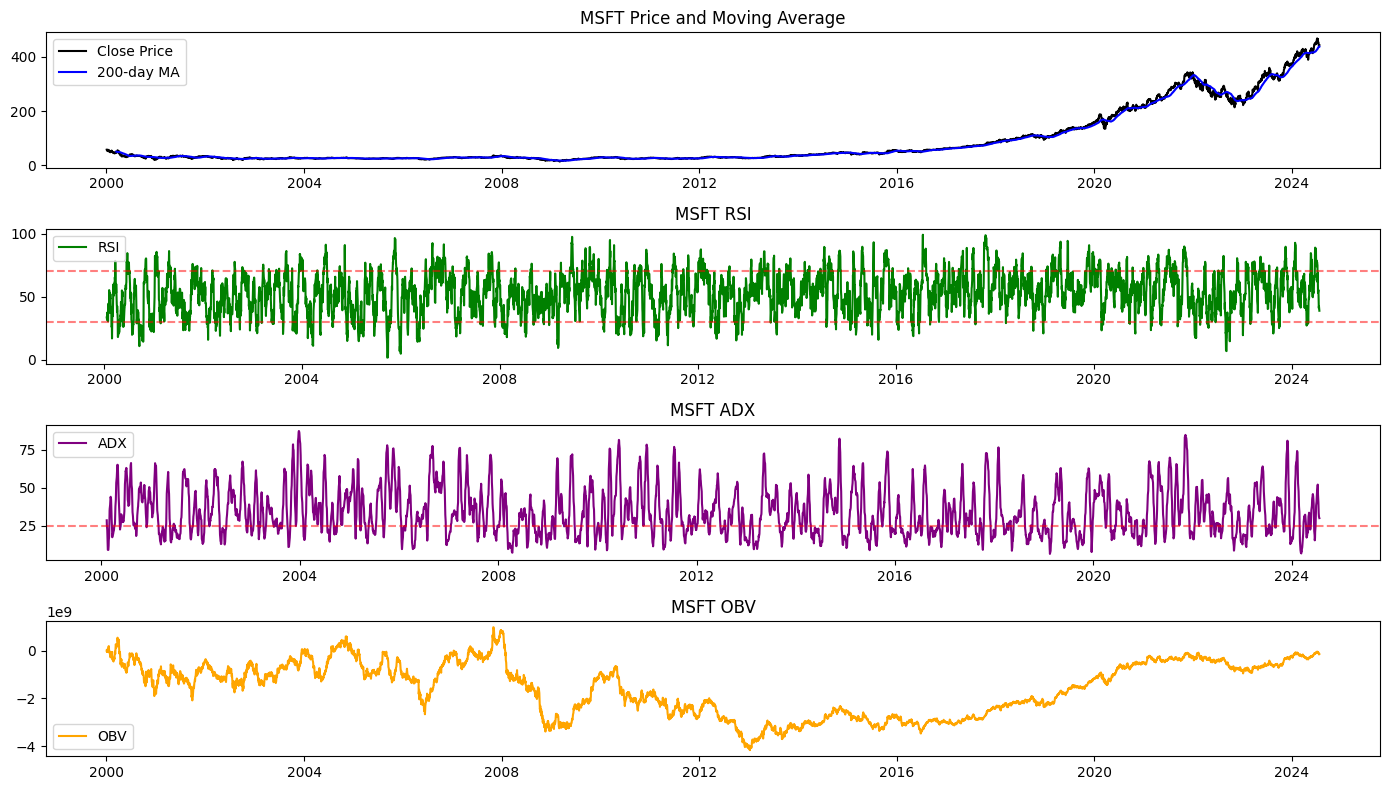

[*********************100%%**********************]  1 of 1 completed


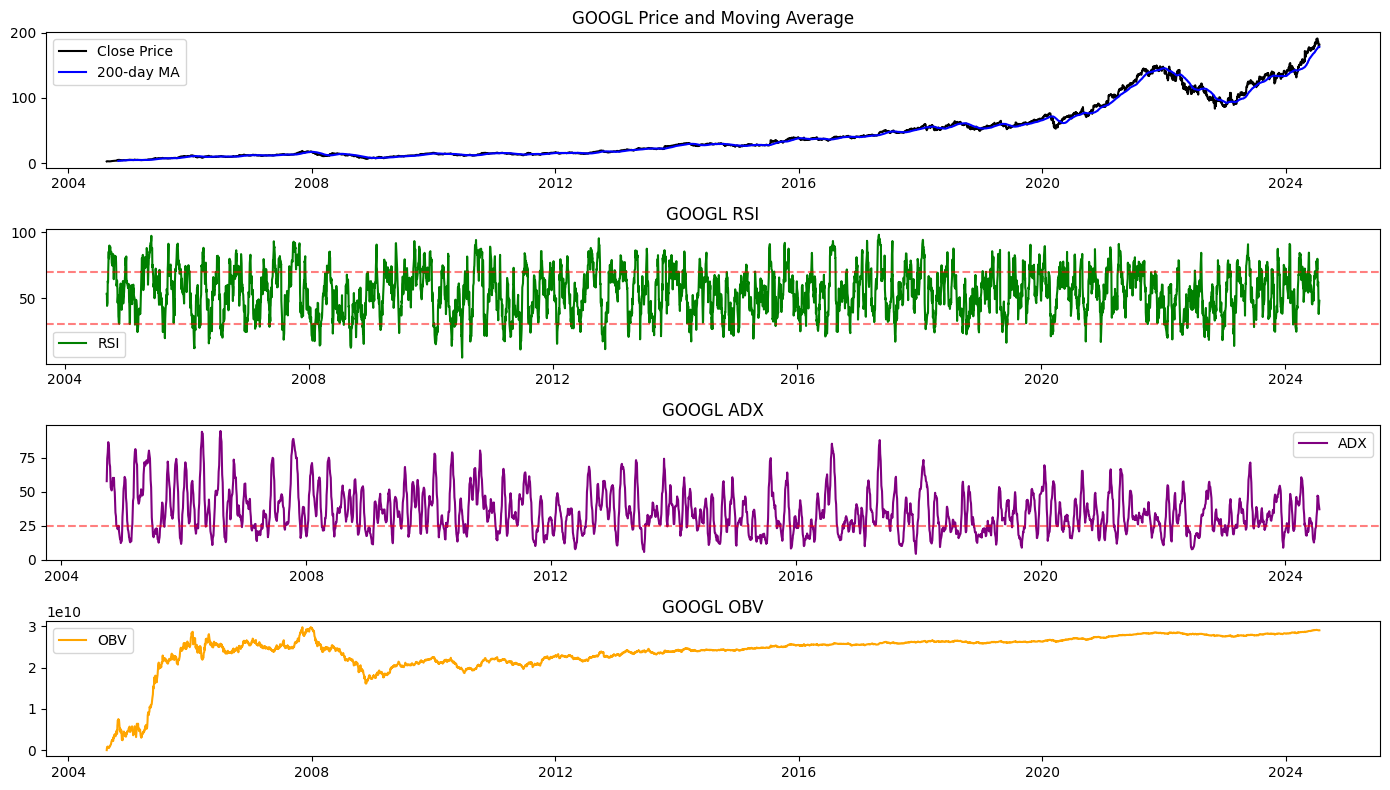


Final Results:
  Ticker  Current Moving Average  Current RSI  Current ADX  Current OBV  \
0   AAPL                206.9556    59.010257    38.983496  90884772300   
1   MSFT                437.8702    38.761200    30.142076   -146849400   
2  GOOGL                178.5658    47.929723    37.071831  29022619448   

   Score Recommendation  
0    0.5            Buy  
1    0.3           Hold  
2    0.3           Hold  


In [3]:
#Buy-sell-hold score based on technical indicators

import yfinance as yf  # Import the yfinance library for downloading stock data
import pandas as pd  # Import pandas for data manipulation
import numpy as np  # Import numpy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Define the ticker symbols of the stocks you want to analyze
ticker_symbols = ['AAPL', 'MSFT', 'GOOGL']  # You can add more tickers to this list

# Function to calculate technical indicators
def calculate_indicators(data):
    # Calculate 50-day Moving Average
    data['MA'] = data['Close'].rolling(window=50).mean()

    # Calculate RSI
    delta = data['Close'].diff()  # Calculate the difference in closing prices
    gain = delta.where(delta > 0, 0)  # Positive gains
    loss = -delta.where(delta < 0, 0)  # Negative losses
    avg_gain = gain.rolling(window=14).mean()  # Average gain over 14 days
    avg_loss = loss.rolling(window=14).mean()  # Average loss over 14 days
    rs = avg_gain / avg_loss  # Relative strength
    rsi = 100 - (100 / (1 + rs))  # Relative Strength Index calculation
    data['RSI'] = rsi

    # Calculate ADX
    data['UpMove'] = data['High'] - data['High'].shift(1)  # Upward price movement
    data['DownMove'] = data['Low'].shift(1) - data['Low']  # Downward price movement
    data['PosDM'] = data['UpMove'].where(data['UpMove'] > data['DownMove'], 0)  # Positive directional movement
    data['NegDM'] = data['DownMove'].where(data['DownMove'] > data['UpMove'], 0)  # Negative directional movement
    data['TR'] = np.maximum.reduce([data['High'] - data['Low'], abs(data['High'] - data['Close'].shift(1)), abs(data['Low'] - data['Close'].shift(1))])  # True Range
    data['ATR'] = data['TR'].rolling(window=14).mean()  # Average True Range
    data['PosDI'] = 100 * (data['PosDM'].rolling(window=14).mean() / data['ATR'])  # Positive Directional Index
    data['NegDI'] = 100 * (data['NegDM'].rolling(window=14).mean() / data['ATR'])  # Negative Directional Index
    data['DX'] = 100 * abs(data['PosDI'] - data['NegDI']) / (data['PosDI'] + data['NegDI'])  # Directional Movement Index
    data['ADX'] = data['DX'].rolling(window=14).mean()  # Average Directional Index

    # Calculate OBV
    data['OBV'] = (data['Volume'] * (data['Close'] > data['Close'].shift(1)).astype(int) -
                   data['Volume'] * (data['Close'] < data['Close'].shift(1)).astype(int)).cumsum()  # On-Balance Volume

    return data

# Function to predict stock action based on current technical indicators
def predict_action(data, ticker):
    last_row = data.iloc[-1]  # Get the last row of the data for the latest indicators

    # Determine primary and secondary conditions
    ma_buy = int(last_row['Close'] > last_row['MA'])  # Condition for MA buy signal
    ma_sell = int(last_row['Close'] < last_row['MA'])  # Condition for MA sell signal
    rsi_buy = int(last_row['RSI'] < 30)  # Condition for RSI buy signal
    rsi_sell = int(last_row['RSI'] > 70)  # Condition for RSI sell signal

    # Evaluate ADX and OBV for additional confirmation
    adx_buy = int(last_row['ADX'] > 25 and last_row['PosDI'] > last_row['NegDI'])  # Condition for ADX buy signal
    adx_sell = int(last_row['ADX'] > 25 and last_row['NegDI'] > last_row['PosDI'])  # Condition for ADX sell signal
    obv_buy = int(last_row['OBV'] > data['OBV'].iloc[-2])  # Condition for OBV buy signal
    obv_sell = int(last_row['OBV'] < data['OBV'].iloc[-2])  # Condition for OBV sell signal

    return ma_buy, rsi_buy, adx_buy, obv_buy, ma_sell, rsi_sell, adx_sell, obv_sell

# Function to calculate the signal score
def calculate_signal(ma_buy, rsi_buy, adx_buy, obv_buy, ma_sell, rsi_sell, adx_sell, obv_sell):
    # Define weights for each indicator
    weights = {
        'ma_buy': 0.4,
        'rsi_buy': 0.2,
        'adx_buy': 0.25,
        'obv_buy': 0.15,
        'ma_sell': -0.4,
        'rsi_sell': -0.2,
        'adx_sell': -0.25,
        'obv_sell': -0.15
    }

    # Calculate the weighted sum
    score = (
        weights['ma_buy'] * ma_buy +
        weights['rsi_buy'] * rsi_buy +
        weights['adx_buy'] * adx_buy +
        weights['obv_buy'] * obv_buy +
        weights['ma_sell'] * ma_sell +
        weights['rsi_sell'] * rsi_sell +
        weights['adx_sell'] * adx_sell +
        weights['obv_sell'] * obv_sell
    )

    # Determine recommendation based on the score
    if score > 0.33:
        recommendation = 'Buy'
    elif score < -0.33:
        recommendation = 'Sell'
    else:
        recommendation = 'Hold'

    return score, recommendation

# Plotting the indicators for visualization
def plot_indicators(data, ticker):
    plt.figure(figsize=(14, 8))

    # Plot Close Price and Moving Average
    plt.subplot(4, 1, 1)
    plt.plot(data['Close'], label='Close Price', color='black')
    plt.plot(data['MA'], label='200-day MA', color='blue')
    plt.title(f"{ticker} Price and Moving Average")
    plt.legend()

    # Plot RSI
    plt.subplot(4, 1, 2)
    plt.plot(data['RSI'], label='RSI', color='green')
    plt.axhline(30, linestyle='--', alpha=0.5, color='red')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')
    plt.title(f"{ticker} RSI")
    plt.legend()

    # Plot ADX
    plt.subplot(4, 1, 3)
    plt.plot(data['ADX'], label='ADX', color='purple')
    plt.axhline(25, linestyle='--', alpha=0.5, color='red')
    plt.title(f"{ticker} ADX")
    plt.legend()

    # Plot OBV
    plt.subplot(4, 1, 4)
    plt.plot(data['OBV'], label='OBV', color='orange')
    plt.title(f"{ticker} OBV")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Create an empty DataFrame to store the results
results = pd.DataFrame(columns=['Ticker', 'Current Moving Average', 'Current RSI', 'Current ADX', 'Current OBV', 'Score', 'Recommendation'])

# Iterate through the ticker symbols
for ticker in ticker_symbols:
    try:
        # Download historical data for the current ticker
        data = yf.download(ticker, start='2000-01-01')

        # Skip if no data
        if data.empty:
            print(f"No data for {ticker}, possibly delisted.")
            continue

        # Calculate current indicators
        data = calculate_indicators(data)

        # Predict current action
        ma_buy, rsi_buy, adx_buy, obv_buy, ma_sell, rsi_sell, adx_sell, obv_sell = predict_action(data, ticker)

        # Calculate signal score
        score, signal_recommendation = calculate_signal(ma_buy, rsi_buy, adx_buy, obv_buy, ma_sell, rsi_sell, adx_sell, obv_sell)

        # Append the results to the DataFrame
        new_row = pd.DataFrame({
            'Ticker': [ticker],
            'Current Moving Average': [data['MA'].iloc[-1]],
            'Current RSI': [data['RSI'].iloc[-1]],
            'Current ADX': [data['ADX'].iloc[-1]],
            'Current OBV': [data['OBV'].iloc[-1]],
            'Score': [score],
            'Recommendation': [signal_recommendation]
        })

        results = pd.concat([results, new_row], ignore_index=True)

        #Plot indicators for the current ticker
        plot_indicators(data, ticker)








    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Print the final results
print("\nFinal Results:")
print(results)

[*********************100%%**********************]  1 of 1 completed


Downloaded 274 data points for AAPL
Ticker: AAPL
Recommendation Date: 2024-06-06 00:00:00
Recommendation: Buy
Price on Recommendation Date: 194.47999572753906
Price Today: 223.9600067138672
Correct Prediction: True



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Downloaded 274 data points for MSFT
Ticker: MSFT
Recommendation Date: 2024-06-06 00:00:00
Recommendation: Hold
Price on Recommendation Date: 424.5199890136719
Price Today: 442.94000244140625
Correct Prediction: True

Downloaded 274 data points for GOOGL
Ticker: GOOGL
Recommendation Date: 2024-06-06 00:00:00
Recommendation: Hold
Price on Recommendation Date: 176.72999572753906
Price Today: 181.6699981689453
Correct Prediction: True



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed


Downloaded 274 data points for AMZN
Ticker: AMZN
Recommendation Date: 2024-06-06 00:00:00
Recommendation: Sell
Price on Recommendation Date: 185.0
Price Today: 182.5500030517578
Correct Prediction: False

Downloaded 0 data points for FB
Insufficient data to calculate indicators for FB.
Downloaded 274 data points for TSLA


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Ticker: TSLA
Recommendation Date: 2024-06-06 00:00:00
Recommendation: Buy
Price on Recommendation Date: 177.94000244140625
Price Today: 251.50999450683594
Correct Prediction: True

Downloaded 274 data points for NVDA
Ticker: NVDA
Recommendation Date: 2024-06-06 00:00:00
Recommendation: Buy
Price on Recommendation Date: 120.99800109863281
Price Today: 123.54000091552734
Correct Prediction: False

Downloaded 274 data points for NFLX
Ticker: NFLX
Recommendation Date: 2024-06-06 00:00:00
Recommendation: Buy
Price on Recommendation Date: 648.52001953125
Price Today: 647.5
Correct Prediction: False



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Downloaded 274 data points for ADBE
Ticker: ADBE
Recommendation Date: 2024-06-06 00:00:00
Recommendation: Buy
Price on Recommendation Date: 458.1300048828125
Price Today: 554.8200073242188
Correct Prediction: True

Downloaded 274 data points for PYPL
Ticker: PYPL
Recommendation Date: 2024-06-06 00:00:00
Recommendation: Hold
Price on Recommendation Date: 67.0199966430664
Price Today: 60.77000045776367
Correct Prediction: True

  correct_predictions:  6
  total_predictions:  9
  Overall Accuracy: 66.67%


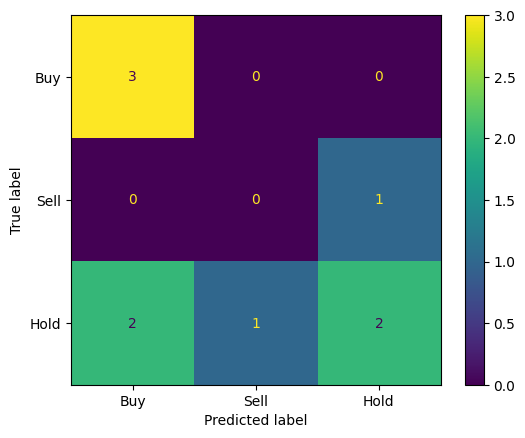

In [18]:
# Final version with confusion matrix
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the ticker symbols of the stocks you want to analyze
ticker_symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "FB", "TSLA", "NVDA", "NFLX", "ADBE", "PYPL"]
#   "AAPL", "MSFT", "GOOGL", "AMZN", "FB", "TSLA", "BRK-B", "V", "JNJ", "WMT",
#     "JPM", "MA", "PG", "UNH", "NVDA", "DIS", "HD", "PYPL", "VZ", "ADBE",
#     "NFLX", "CMCSA", "INTC", "KO", "PFE", "T", "CSCO", "MRK", "PEP", "XOM",
#     "NKE", "WFC", "ABT", "ABBV", "ACN", "MDT", "CRM", "TMO", "LLY", "ORCL",
#     "MCD", "CVX", "AMGN", "HON", "COST", "TXN", "LIN", "UNP", "AVGO", "DHR",
#     "QCOM", "BMY", "NEE", "PM", "LOW", "IBM", "UPS", "SBUX", "RTX", "BA",
#     "MMM", "CHTR", "CAT", "GS", "SPGI", "MS", "GE", "NOW", "INTU",
#     "AXP", "ISRG", "BLK", "ZTS", "CI", "PLD", "TGT", "LMT", "AMD", "ADI",
#     "SYK", "MO", "MDLZ", "BKNG", "GILD", "BDX", "EW", "MMC", "TFC", "EL",
#     "ILMN", "ATVI", "ICE", "C", "NSC", "SO", "REGN", "HUM", "FIS",
#     "FISV", "AON", "CCI", "MTCH", "EXC", "TT", "BAX", "CTSH", "ECL", "D",
#     "MCK", "CME", "SHW", "SPG", "DG", "NOC", "DGX", "VLO", "AEP", "ITW",
#     "CDNS", "ED", "MAR", "WMB", "DLR", "CTAS", "PSA", "APD", "RMD", "SYY",
#     "CMG", "ADM", "ORLY", "EOG", "BK", "TROW", "AIG", "HCA", "MSCI", "PSX",
#     "LVS", "XEL", "PGR", "TDG", "AME", "MCO", "F", "KMB", "STZ", "DFS",
#     "EA", "SNPS", "PPL", "VRSK", "TEL", "SWK", "SBAC", "ETN", "WBA", "PCAR",
#     "AWK", "DHI", "VFC", "EXR", "KEYS", "AEE", "OKE", "TRV", "WLTW", "MPC",
#     "EFX", "CLX", "VMC", "FTNT", "FLT", "PEG", "CNP", "FTV", "DOV", "ETR",
#     "MLM", "WST", "ATO", "CTVA", "HIG", "BKR", "PKI", "GPN", "CHD", "CNC",
#     "TSN", "ROL", "MTD", "NI", "WY", "VTR", "ANSS", "FMC", "XYL", "MKC",
#     "DRI", "SIVB", "IEX", "TSCO", "LYB", "STE", "PFG", "NDAQ", "RF", "HSY",
#     "CAG", "LKQ", "PHM", "O", "CMS", "AFL", "IR", "AVY", "MSI", "AKAM",
#     "RSG", "ESS", "ZBRA", "TYL", "AOS", "RJF", "RE", "UDR", "HOLX", "L",
#     "FANG", "MAS", "HPE", "HES", "EPAM", "UAL", "BBY", "CINF", "INCY", "RPM",
#     "CPRT", "TRMB", "CMA", "EVRG", "CBOE", "ALLE", "GL", "LHX", "WHR", "ARE",
#     "SWKS", "BIO", "JKHY", "LNT", "JBHT", "CTLT", "BXP", "OMC", "EXPD",
#     "ZION", "TXT", "AVB", "HST", "FBHS", "NTAP", "LDOS", "BBWI", "XRAY",
#     "HII", "WRB", "TAP", "PNR", "WAB", "WU", "HBAN", "LUMN", "VTRS", "BWA",
#     "CCL", "NRG", "NWSA", "HBI", "CPB", "KMX", "HAS", "NLOK", "KIM", "MOS",
#     "CF", "IRM", "JNPR", "APA", "ALB", "AVTR", "MRO", "NUE", "IP", "AAP",
#     "CZR", "DISCA", "DISCK", "DISH", "HAL", "MHK", "NLSN", "SBNY", "DVA",
#     "IPG", "DVN", "NWL", "XRX", "PWR", "NCLH", "HFC", "LB", "VNT", "NDSN",
#     "LNC", "LPLA", "LW", "WRK", "TPR", "CDW", "HSIC", "EQT", "AAL", "PBCT",
#     "DXC", "UAL", "VNO", "MGM", "FRT", "XRAY", "UHS", "HBI", "KMX", "MOS",
#     "JNPR", "IPG", "DVA", "HFC", "MTD", "NI", "VTR", "ANSS", "XYL", "MKC",
#     "DRI", "SIVB", "IEX", "TSCO", "LYB", "STE", "NDAQ", "RF", "HSY", "CAG",
#     "LKQ", "PHM", "CMS", "AFL", "IR", "AVY", "MSI", "AKAM", "RSG", "ESS",
#     "ZBRA", "TYL", "AOS", "RJF", "RE", "HOLX", "L", "MAS", "HPE", "HES",
#     "EPAM", "BBY", "CINF", "INCY", "RPM", "CPRT", "TRMB", "CMA", "EVRG",
#     "CBOE", "ALLE", "GL", "LHX", "WHR", "ARE", "SWKS", "BIO", "JKHY", "LNT",
#     "JBHT", "CTLT", "BXP", "OMC", "EXPD", "ZION", "TXT", "AVB", "HST",
#     "FBHS", "NTAP", "LDOS", "XRAY", "HII", "WRB", "TAP", "PNR", "WAB", "WU",
#     "HBAN", "LUMN", "VTRS", "BWA", "CCL", "NRG", "NWSA", "CPB", "KMX", "HAS",
#     "NLOK", "KIM", "CF", "IRM", "APA", "ALB", "AVTR", "MRO", "NUE", "IP",
#     "AAP", "CZR", "DISCA", "DISCK", "DISH", "HAL", "MHK", "NLSN", "SBNY",
#     "DVA", "IPG", "DVN", "NWL", "XRX", "PWR", "NCLH", "HFC", "LB", "VNT",
#     "NDSN", "LNC", "LPLA", "LW", "WRK", "TPR", "CDW", "HSIC", "EQT", "AAL",
#     "PBCT", "DXC", "UAL", "VNO", "MGM", "FRT", "XRAY", "UHS", "HBI", "KMX",
#     "MOS", "JNPR", "IPG", "DVA", "HFC", "MTD", "NI", "VTR", "ANSS", "XYL",
#     "MKC", "DRI", "SIVB", "IEX", "TSCO", "LYB", "STE", "NDAQ", "RF", "HSY",
#     "CAG", "LKQ", "PHM", "CMS", "AFL", "IR", "AVY", "MSI", "AKAM", "RSG",
#     "ESS", "ZBRA", "TYL", "AOS", "RJF", "RE", "HOLX", "L", "MAS", "HPE",
#     "HES", "EPAM", "BBY", "CINF", "INCY", "RPM", "CPRT", "TRMB", "CMA",
#     "EVRG", "CBOE", "ALLE", "GL", "LHX", "WHR", "ARE", "SWKS", "BIO", "JKHY",
#     "LNT", "JBHT", "CTLT", "BXP", "OMC", "EXPD", "ZION", "TXT", "AVB",
#     "HST", "FBHS", "NTAP", "LDOS", "XRAY", "HII", "WRB", "TAP", "PNR",
#     "WAB", "WU", "HBAN", "LUMN", "VTRS", "BWA", "CCL", "NRG", "NWSA", "CPB",
#     "KMX", "HAS", "NLOK", "KIM", "CF", "IRM", "APA", "ALB", "AVTR", "MRO",
#     "NUE", "IP", "AAP", "CZR", "DISCA", "DISCK", "DISH", "HAL", "MHK", "NLSN",
#     "SBNY", "DVA", "IPG", "DVN", "NWL", "XRX", "PWR", "NCLH", "HFC", "LB",
#     "VNT", "NDSN", "LNC", "LPLA", "LW", "WRK", "TPR", "CDW", "HSIC", "EQT",
#     "AAL", "PBCT", "DXC", "UAL", "VNO", "MGM", "FRT", "XRAY", "UHS", "HBI",
#     "KMX", "MOS", "JNPR", "IPG", "DVA", "HFC"
# ]


# Function to calculate technical indicators
def calculate_indicators(data):
    # Calculate 50-day Moving Average
    data['MA'] = data['Close'].rolling(window=55).mean()

    # Calculate RSI
    delta = data['Close'].diff()  # Calculate the difference in closing prices
    gain = delta.where(delta > 0, 0)  # Positive gains
    loss = -delta.where(delta < 0, 0)  # Negative losses
    avg_gain = gain.rolling(window=14).mean()  # Average gain over 14 days
    avg_loss = loss.rolling(window=14).mean()  # Average loss over 14 days
    rs = avg_gain / avg_loss  # Relative strength
    rsi = 100 - (100 / (1 + rs))  # Relative Strength Index calculation
    data['RSI'] = rsi

    # Calculate ADX
    data['UpMove'] = data['High'] - data['High'].shift(1)  # Upward price movement
    data['DownMove'] = data['Low'].shift(1) - data['Low']  # Downward price movement
    data['PosDM'] = data['UpMove'].where(data['UpMove'] > data['DownMove'], 0)  # Positive directional movement
    data['NegDM'] = data['DownMove'].where(data['DownMove'] > data['UpMove'], 0)  # Negative directional movement
    data['TR'] = np.maximum.reduce([data['High'] - data['Low'], abs(data['High'] - data['Close'].shift(1)), abs(data['Low'] - data['Close'].shift(1))])  # True Range
    data['ATR'] = data['TR'].rolling(window=14).mean()  # Average True Range
    data['PosDI'] = 100 * (data['PosDM'].rolling(window=14).mean() / data['ATR'])  # Positive Directional Index
    data['NegDI'] = 100 * (data['NegDM'].rolling(window=14).mean() / data['ATR'])  # Negative Directional Index
    data['DX'] = 100 * abs(data['PosDI'] - data['NegDI']) / (data['PosDI'] + data['NegDI'])  # Directional Movement Index
    data['ADX'] = data['DX'].rolling(window=14).mean()  # Average Directional Index

    # Calculate OBV
    data['OBV'] = (data['Volume'] * (data['Close'] > data['Close'].shift(1)).astype(int) -
                   data['Volume'] * (data['Close'] < data['Close'].shift(1)).astype(int)).cumsum()  # On-Balance Volume

    return data

# Function to predict stock action based on current technical indicators
def predict_action(data, ticker):
    last_row = data.iloc[-1]  # Get the last row of the data for the latest indicators

    # Determine primary and secondary conditions
    ma_buy = int(last_row['Close'] > last_row['MA'])  # Condition for MA buy signal
    ma_sell = int(last_row['Close'] < last_row['MA'])  # Condition for MA sell signal
    rsi_buy = int(last_row['RSI'] < 30)  # Condition for RSI buy signal
    rsi_sell = int(last_row['RSI'] > 70)  # Condition for RSI sell signal

    # Evaluate ADX and OBV for additional confirmation
    adx_buy = int(last_row['ADX'] > 25 and last_row['PosDI'] > last_row['NegDI'])  # Condition for ADX buy signal
    adx_sell = int(last_row['ADX'] > 25 and last_row['NegDI'] > last_row['PosDI'])  # Condition for ADX sell signal
    obv_buy = int(last_row['OBV'] > data['OBV'].iloc[-2])  # Condition for OBV buy signal
    obv_sell = int(last_row['OBV'] < data['OBV'].iloc[-2])  # Condition for OBV sell signal

    return ma_buy, rsi_buy, adx_buy, obv_buy, ma_sell, rsi_sell, adx_sell, obv_sell



# Function to calculate the signal score
def calculate_signal(ma_buy, rsi_buy, adx_buy, obv_buy, ma_sell, rsi_sell, adx_sell, obv_sell):
    # Define weights for each indicator
    weights = {
        'ma_buy': 0.4,
        'rsi_buy': 0.2,
        'adx_buy': 0.25,
        'obv_buy': 0.15,
        'ma_sell': -0.4,
        'rsi_sell': -0.2,
        'adx_sell': -0.25,
        'obv_sell': -0.15
    }

    # Calculate the weighted sum
    score = (
        weights['ma_buy'] * ma_buy +
        weights['rsi_buy'] * rsi_buy +
        weights['adx_buy'] * adx_buy +
        weights['obv_buy'] * obv_buy +
        weights['ma_sell'] * ma_sell +
        weights['rsi_sell'] * rsi_sell +
        weights['adx_sell'] * adx_sell +
        weights['obv_sell'] * obv_sell
    )

    # Determine recommendation based on the score
    if score > 0.33:
        recommendation = 'Buy'
    elif score < -0.33:
        recommendation = 'Sell'
    else:
        recommendation = 'Hold'

    return score, recommendation

# Function to generate recommendations for the past month
def generate_past_month_recommendations(ticker):
    end_date = pd.to_datetime('today')
    start_date = end_date - pd.DateOffset(days=400)  # Get data for the past 400 days to ensure we have enough for the 200-day MA
    data = yf.download(ticker, start=start_date, end=end_date)

    # Log the length of the downloaded data
    print(f"Downloaded {len(data)} data points for {ticker}")

    # Ensure there is sufficient data
    if len(data) < 200:
        print(f"Insufficient data to calculate indicators for {ticker}.")
        return None, None, None

    data = calculate_indicators(data)

    # Ensure we have data for at least one month after the 200-day MA period
    if len(data.dropna()) < 31:
        print(f"Insufficient data after calculating indicators for {ticker}.")
        return None, None, None

    # Get the recommendation for the last date in the data
    recommendation_date = data.dropna().index[-31]  # 31 days back from today to ensure one month ago
    ma_buy, rsi_buy, adx_buy, obv_buy, ma_sell, rsi_sell, adx_sell, obv_sell = predict_action(data, ticker)
    score, recommendation = calculate_signal(ma_buy, rsi_buy, adx_buy, obv_buy, ma_sell, rsi_sell, adx_sell, obv_sell)

    return recommendation, recommendation_date, data

# Function to evaluate recommendation against actual performance
def evaluate_recommendation(ticker, recommendation, recommendation_date, data):
    actual_price_today = data.loc[data.index[-1], 'Close']
    price_on_recommendation_date = data.loc[recommendation_date, 'Close']

    correct_prediction = False
    if recommendation == 'Buy' and actual_price_today > 1.05 * (price_on_recommendation_date):
        correct_prediction = True
    elif recommendation == 'Sell' and actual_price_today < 0.95 * (price_on_recommendation_date):
        correct_prediction = True
    elif recommendation == 'Hold': #and actual_price_today < 1.05 * (price_on_recommendation_date) and actual_price_today > 0.95 * (price_on_recommendation_date):
        correct_prediction = True  # Assume hold is always correct

    return correct_prediction, price_on_recommendation_date, actual_price_today, recommendation

# Main loop to calculate and print accuracy
total_predictions = 0
correct_predictions = 0

predictions = []
actuals = []

for ticker in ticker_symbols:
    recommendation, recommendation_date, data = generate_past_month_recommendations(ticker)

    # Skip evaluation if there is insufficient data
    if recommendation is None:
        continue

    correct_prediction, price_on_recommendation_date, actual_price_today, recommendation = evaluate_recommendation(ticker, recommendation, recommendation_date, data)

    # Determine the actual label based on the price change
    if actual_price_today > 1.05 * (price_on_recommendation_date):
      actual_label = 'Buy'
    elif actual_price_today < 0.95 * (price_on_recommendation_date):
      actual_label = 'Sell'
    else:
      actual_label = 'Hold'





    predictions.append(recommendation)
    actuals.append(actual_label)

    total_predictions += 1
    if correct_prediction:
        correct_predictions += 1

    print(f'Ticker: {ticker}')
    print(f'Recommendation Date: {recommendation_date}')
    print(f'Recommendation: {recommendation}')
    print(f'Price on Recommendation Date: {price_on_recommendation_date}')
    print(f'Price Today: {actual_price_today}')
    print(f'Correct Prediction: {correct_prediction}\n')

accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0
print("  correct_predictions: ",correct_predictions)
print("  total_predictions: ", total_predictions)
print(f'  Overall Accuracy: {accuracy:.2f}%')

# Calculate and display confusion matrix
conf_matrix = confusion_matrix(actuals, predictions, labels=['Buy', 'Sell', 'Hold'])
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Buy', 'Sell', 'Hold'])
cmd.plot()
plt.show()
